In [1]:
import pandas as pd
import numpy as np

from sklearn import cluster as cl
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt; plt.rcdefaults()
from pylab import *
%matplotlib inline

from collections import defaultdict
from unicodedata import normalize
from math import ceil
from pprint import pprint
from tqdm import tqdm
import re

import warnings #some models through randint warnings
warnings.filterwarnings("ignore")

csv = pd.read_csv("movie_metadata.csv", engine="python")
training_set = csv
for column in training_set:
    training_set = training_set[training_set[column].notnull()]

In [2]:
to_delete = ["color","director_name","actor_2_name",
            "actor_1_name","movie_title","actor_3_name",
            "plot_keywords","movie_imdb_link"]

for column in to_delete:
    del training_set[column]

training_set["genres"] = [x.split("|") for x in training_set["genres"]]

In [3]:
all_genres = list()
new_genres = list()

all_langs = list()
new_langs = list()

def listify(name, isList=False): 
    """
    for example turns "USA" into [1.0,0.0,0.0,0.0...]
    """
    all_items = list()
    new_items = list()
    if isList:
        for l in training_set[name]:
            for item in l:
                if item not in all_items:
                    all_items.append(item)

        for l in training_set[name]:
            items_for_movie = list()
            for item in all_items:
                items_for_movie.append(float(item in l))
            new_items.append(items_for_movie)
    else:
        for item in training_set[name]:
            if item not in all_items:
                all_items.append(item)

        for item in training_set[name]:
            items_for_movie = list()
            for check_item in all_items:
                items_for_movie.append(float(check_item==item))
            new_items.append(items_for_movie)
    return new_items

training_set["genres"] = listify("genres", isList=True)
training_set["language"] = listify("language")
training_set["country"] = listify("country")
training_set["content_rating"] = listify("content_rating")

In [4]:
lenList = list()
flatfeatures = list()

for item in training_set.iloc[[1]].values[0]:
    try:
        lenList.append(len(item))
    except TypeError:
        lenList.append(1)

for index, row in training_set.iterrows():
    flatRow = list()
    for item in row:
        try:
            flatRow.extend(item)
        except TypeError:
            flatRow.append(item)
    flatfeatures.append(flatRow)

In [5]:
# confirming that -1 means noisy data
iris = load_iris()
dbscan_test = cl.DBSCAN().fit(iris.data)

In [47]:
def get_labels(to_search, model=cl.KMeans(), plot_model=True, plot_labels=True):
    search_list = [[item.strip() for item in subset]
                    for subset in [x.split("=") 
                    for x in to_search.split(",")]]
    model.fit(flatfeatures)
    labels = model.labels_
    labels_list = list()
    label_dictList=[]
    for key, value in search_list: #for every parameter
        indiv_list = list()
        movies = csv[csv[str(key)]==str(value)]
        indexes = list(movies.index)
        label_dict = {label:[] for label in list(
                set([labels[index] for index in indexes if index<len(labels)]))}
        for index in indexes:
            try:
                indiv_list.append(labels[index])
                label_dict[labels[index]].append( #adds movie title to label_dict
                    normalize("NFKD", csv.loc[[index]]["movie_title"].values[0]).strip())
            except IndexError:
                continue
        labels_list.append(indiv_list)
        label_dictList.append(label_dict)
    
    if plot_model or plot_labels:
        f, axarr = plt.subplots(ceil((len(labels_list)-1)/2)+int(plot_model),
                                1+int(plot_model and plot_labels))
    
    if plot_model:
        model_labels = list(set(labels))
        counts = [list(labels).count(x) for x in model_labels]
        D = {k:v for k, v in zip(model_labels, counts)}
        try:
            ax = axarr[0,0]
        except IndexError:
            ax = axarr[0]
        ax.bar(range(len(D)), D.values(), align='center')
        ax.set_xticks(range(len(D)), D.keys())
        ax.set_ylabel('Number of Occurances')
        ax.set_title('Model Histogram')
        
    if plot_labels:
        for ind, occurance in enumerate(labels_list):
            occuranceLabels = list(set(occurance))
            counts = [list(occurance).count(x) for x in occuranceLabels]
            D = {k:v for k, v in zip(occuranceLabels, counts)}
            try:
                ax = axarr[(ind+int(plot_model))//2,(ind+int(plot_model))%2]
            except IndexError:
                ax = axarr[1]
            ax.bar(range(len(D)), D.values(), align='center')
            ax.set_xticks(range(len(D)), D.keys())
            ax.set_ylabel('Number of Occurances')
            ax.set_title('Histogram for '+str(search_list[ind][1]))
            print(str(search_list[ind][1])+":")
            pprint(label_dictList[ind])
        if ind%2 == 1: # if there is a leftover square, fill in "NO DATA"
            axarr[(ind+int(plot_model))//2, 1].text(0.5, 0.5, #unfotunately you need this:
                                                    '                \
                                                NO DATA',
                                                horizontalalignment='center',
                                                verticalalignment='center',
                                                fontsize=20, color='red',
                                                transform=ax.transAxes)
    plt.tight_layout()
    return labels_list
    #return label_dict

Christopher Nolan:
{0: ['Insomnia', 'The Prestige', 'Memento'],
 3: ['Interstellar', 'Inception'],
 4: ['The Dark Knight Rises', 'The Dark Knight', 'Batman Begins']}


[[4, 4, 3, 3, 4, 0, 0, 0]]

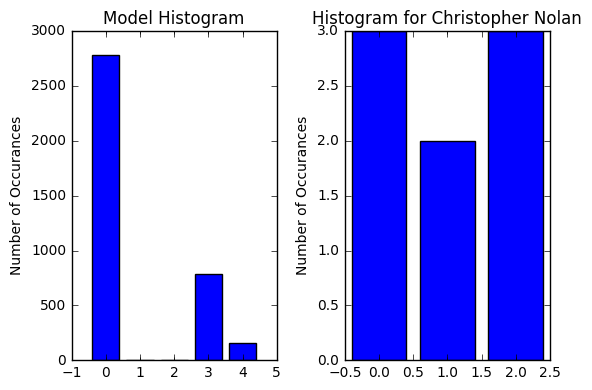

In [48]:
get_labels("director_name=Christopher Nolan",
          model=cl.KMeans(n_clusters=5))

Zack Snyder:
{0: ["Legend of the Guardians: The Owls of Ga'Hoole"],
 4: ['Batman v Superman: Dawn of Justice', 'Man of Steel', 'Sucker Punch'],
 6: ['Watchmen', '300', 'Dawn of the Dead']}
Joss Whedon:
{3: ['Avengers: Age of Ultron', 'The Avengers'], 6: ['Serenity']}


[[4, 4, 6, 0, 4, 6, 6], [3, 3, 6]]

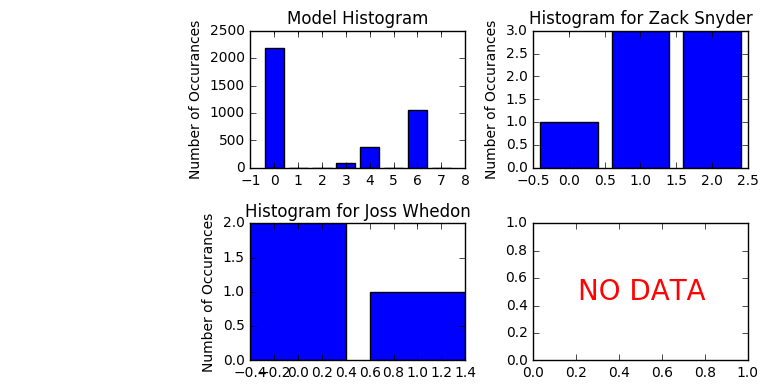

In [49]:
get_labels("director_name=Zack Snyder, director_name=Joss Whedon",
          model=cl.KMeans())

Martin Scorsese:
{1: ['The Wolf of Wall Street', 'Casino'],
 2: ['Bringing Out the Dead', 'Kundun'],
 7: ['Gangs of New York'],
 8: ['The Last Temptation of Christ'],
 9: ['Shutter Island', 'The Age of Innocence'],
 16: ['Hugo'],
 18: ['Mean Streets',
      'Raging Bull',
      'New York, New York',
      'The Color of Money'],
 19: ['Cape Fear', 'Goodfellas'],
 21: ['The Aviator', 'The Departed']}


[[16, 21, 1, 7, 21, 9, 1, 18, 19, 9, 2, 2, 19, 18, 18, 18, 8]]

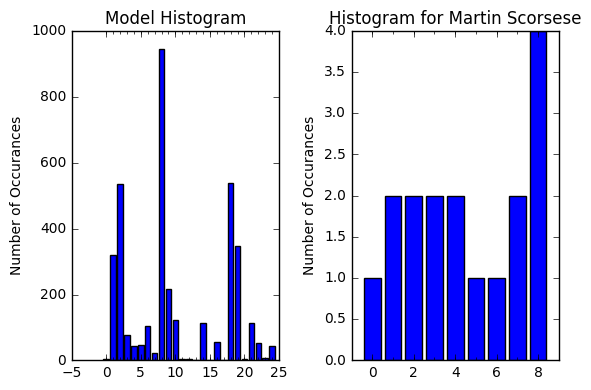

In [50]:
get_labels("director_name=Martin Scorsese",cl.Birch(n_clusters=25))

In [79]:
# Silouhette analysis modified from SKLearn Docs:  
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html


def silhouette(model, diagrams=True, plot=True, max_clusters=10):
    """
    Creates a sillhouete heuristic with optional plots
    Assumes that model takes in n_clusters
    """
    X = np.array(flatfeatures)
    silhouette_score_list = list()
    total_negative_list = list()
    total_negative_num_list = list()

    for n_clusters in range(2, max_clusters+1):
        if diagrams:
            fig, (ax1) = plt.subplots(1, 1)
            fig.figsize = (4, 3)
            ax1.set_xlim([-0.5, 1])

            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        model_name = re.findall(r"(\w+)\(", str(clusterer))[0]

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        total_negative = 0
        total_negative_nums = 0

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            total_negative += sum([x for x in ith_cluster_silhouette_values if x < 0])
            total_negative_nums += len([x for x in ith_cluster_silhouette_values if x < 0])

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            if diagrams:
                color = cm.spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        if diagrams:
            ax1.set_title(" _")
            ax1.set_xlabel("Silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

            plt.suptitle(("Silhouette analysis for "+model_name+" clustering "
                          "with n_clusters = %d " % n_clusters),
                         fontsize=14, fontweight='bold')

            plt.tight_layout()
            plt.show()
        if plot:
            silhouette_score_list.append(silhouette_avg)
            total_negative_list.append(total_negative)
            total_negative_num_list.append(total_negative_nums)
    if plot:
        %matplotlib notebook
        f, axarr = plt.subplots(1,3)
        f.figsize=(10,4)
        ax = axarr[0]
        ax.plot(silhouette_score_list)
        ax.set_title("Average Silhouette Score vs. Clusters \n_\n_")
        ax = axarr[1]
        ax.plot([abs(x) for x in total_negative_list])
        ax.set_title("Sum Negative Values vs. Clusters\n_")
        ax = axarr[2]
        ax.plot(total_negative_num_list)
        ax.set_title("Total Negative Values/Clusters vs. Clusters")
        plt.show()
    %matplotlib inline
    return

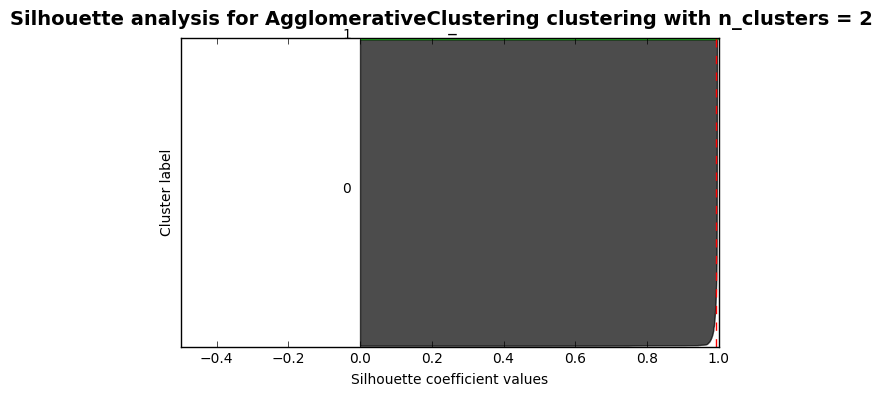

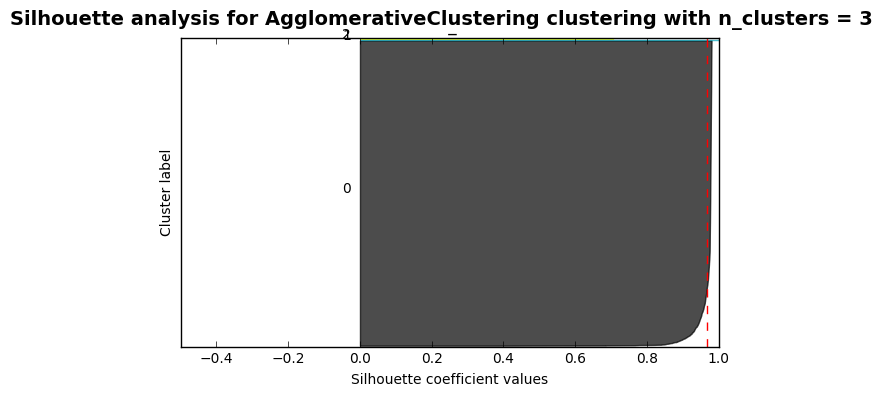

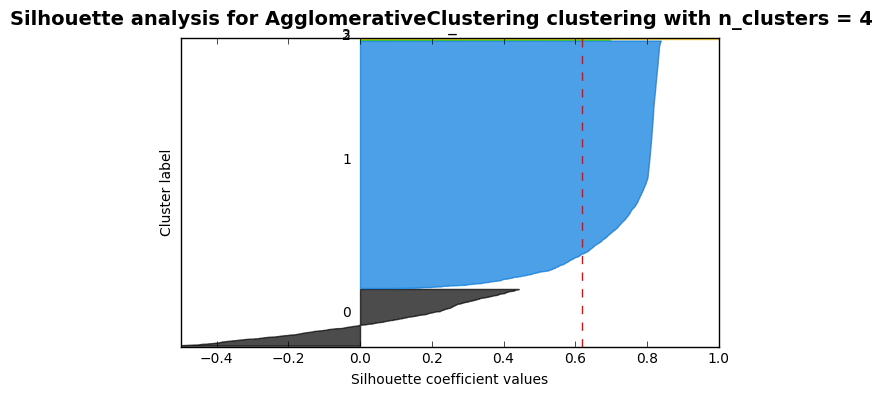

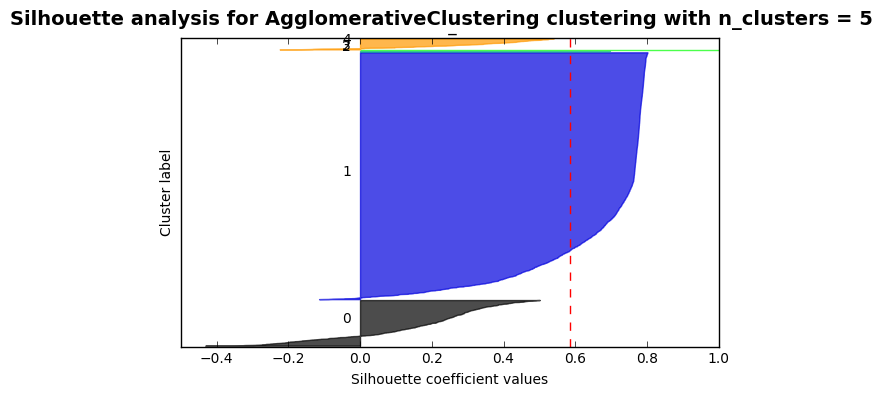

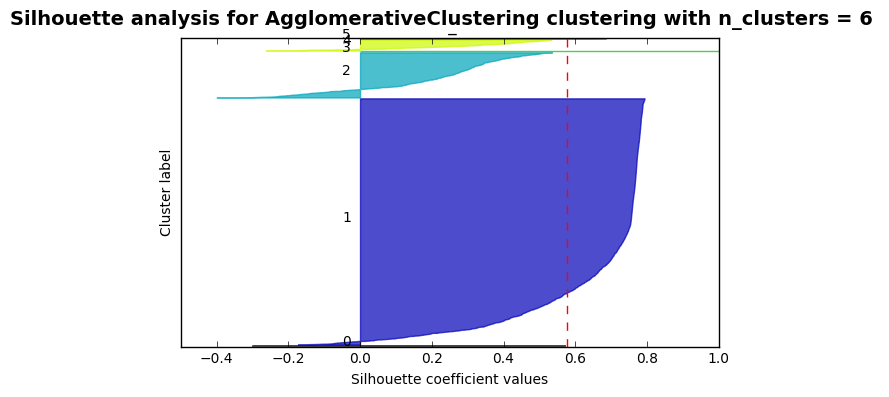

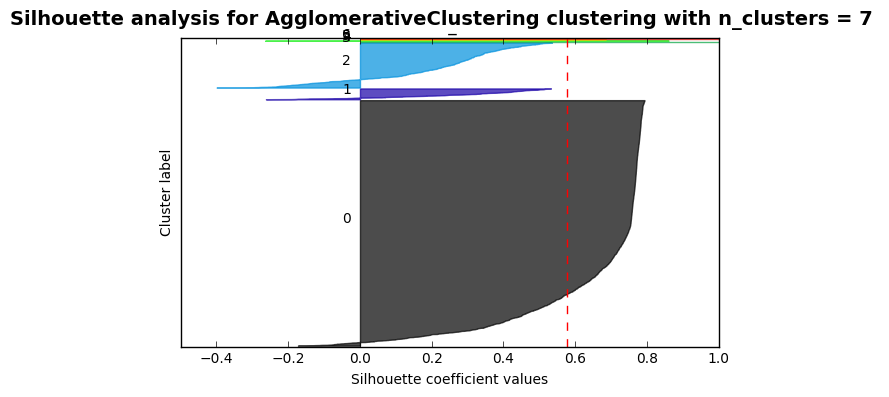

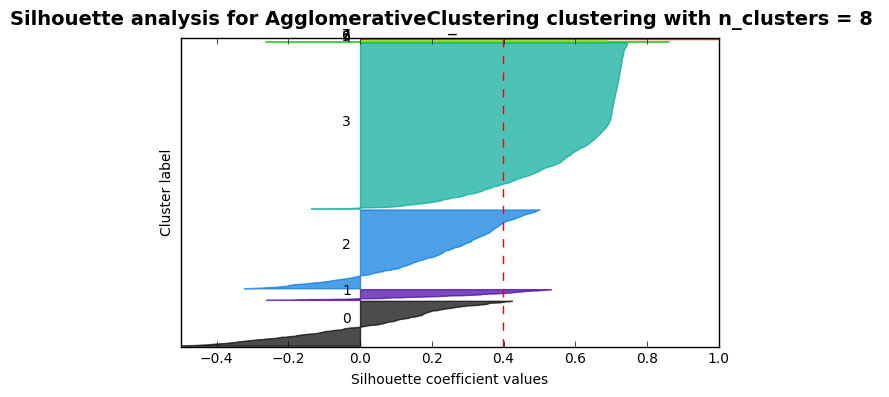

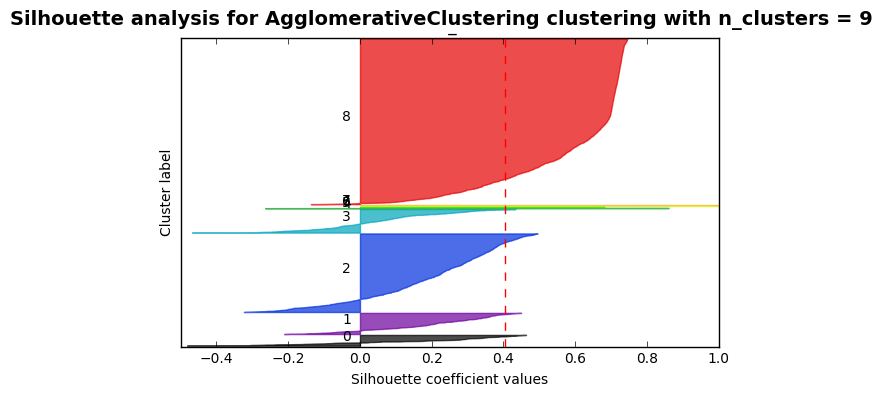

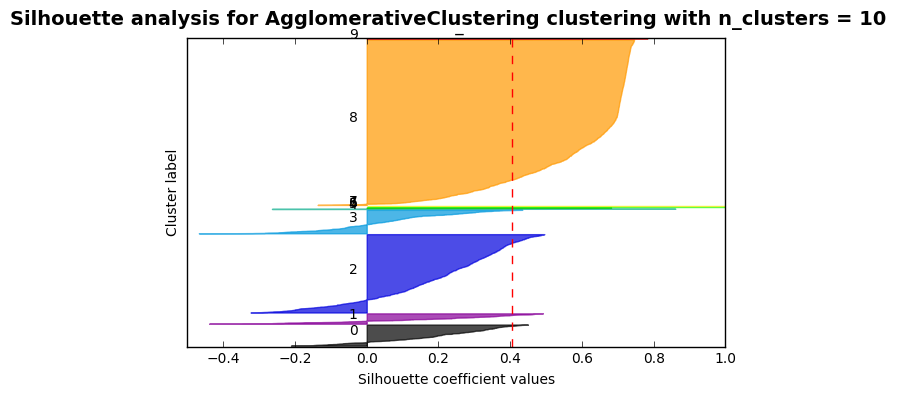

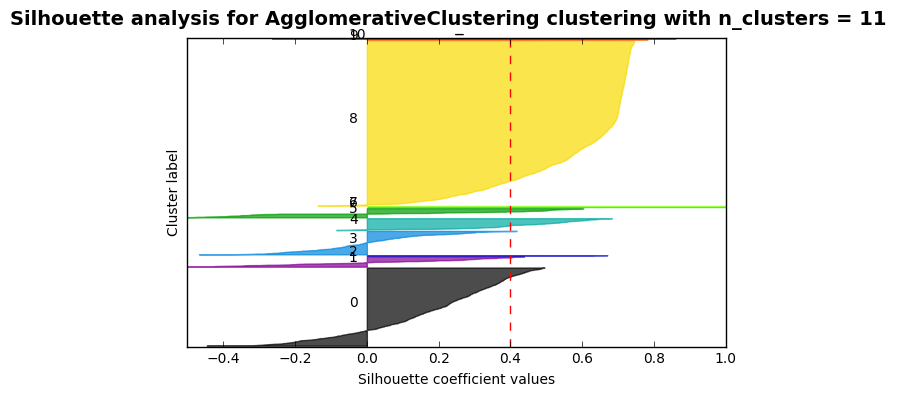

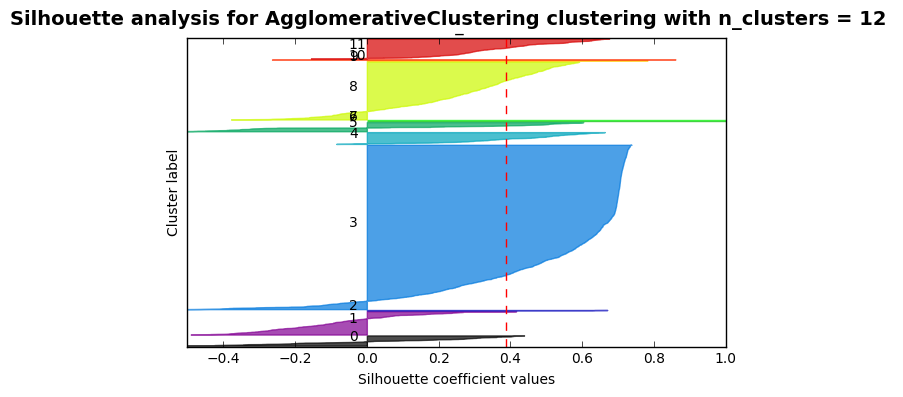

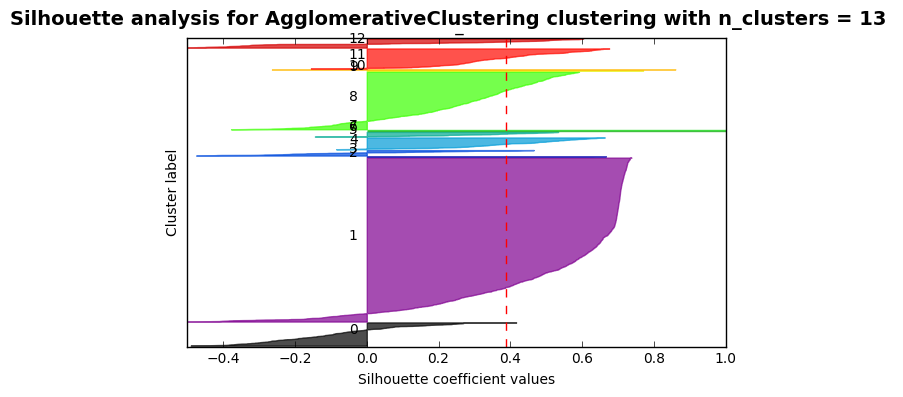

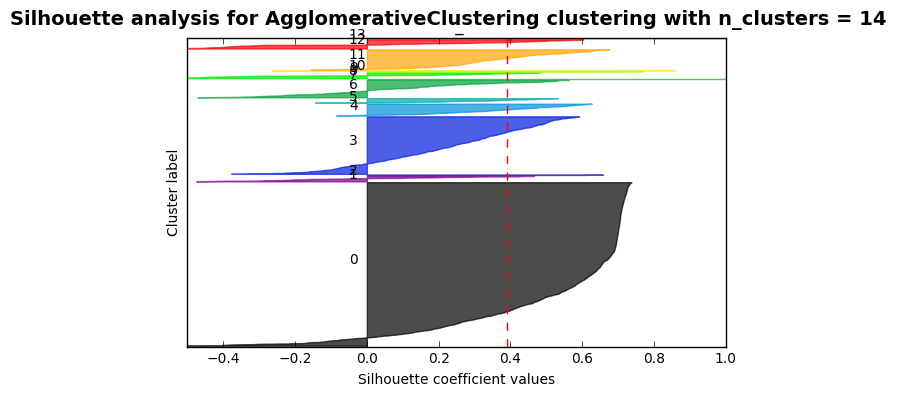

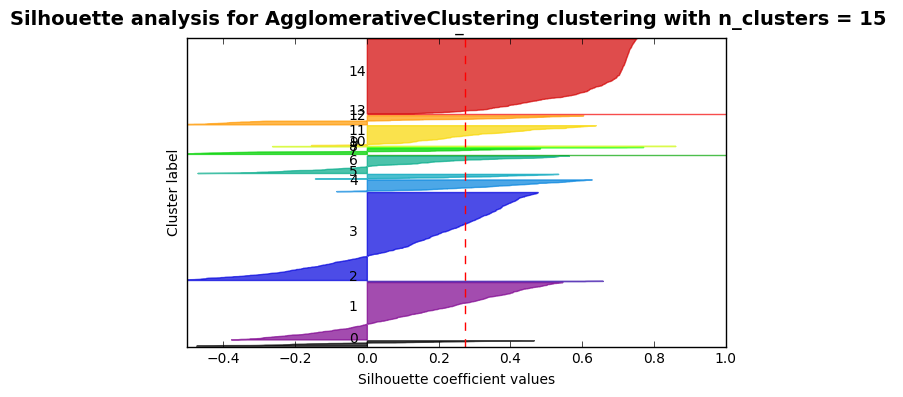

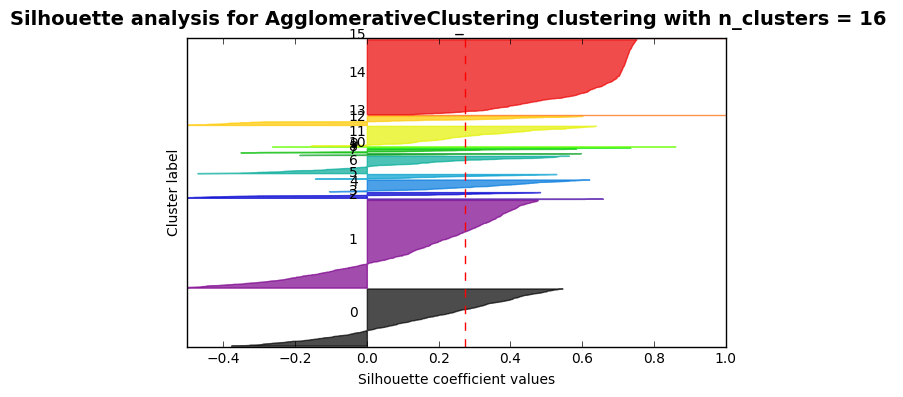

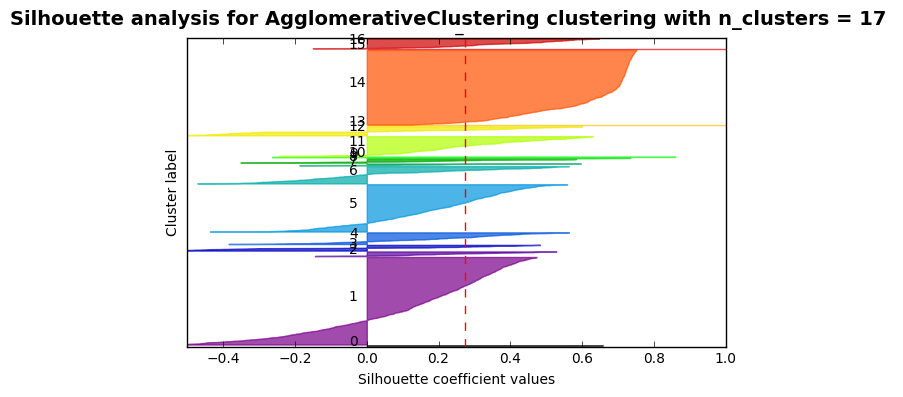

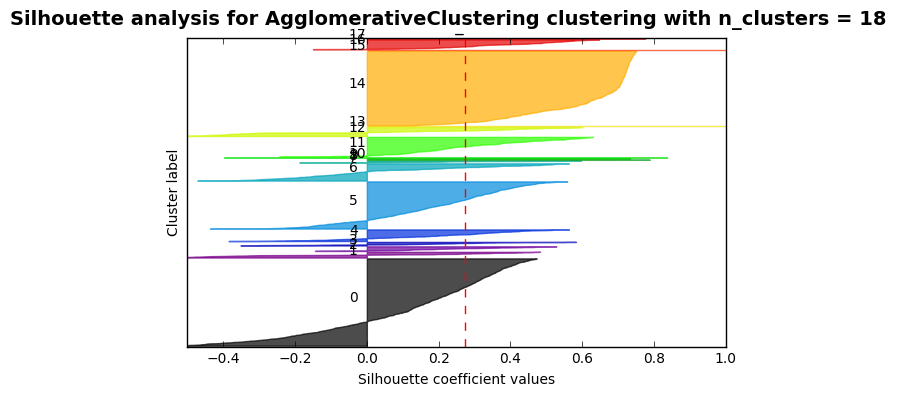

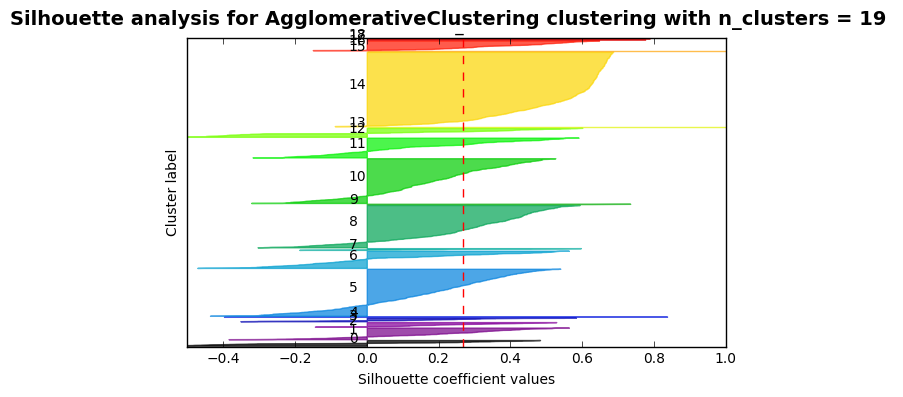

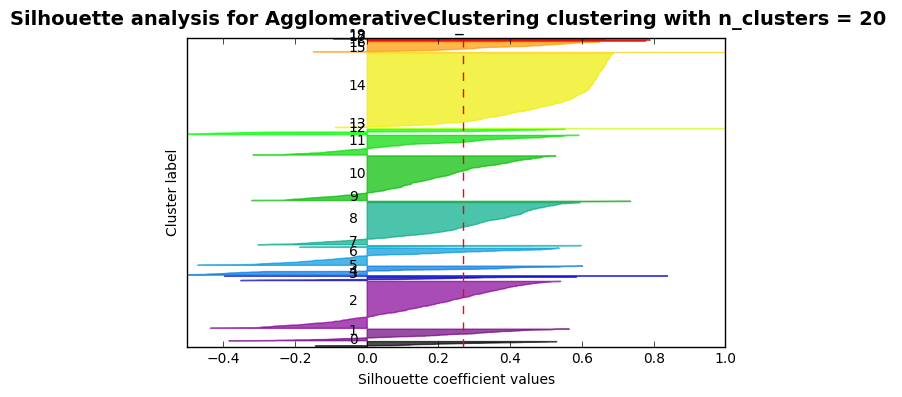

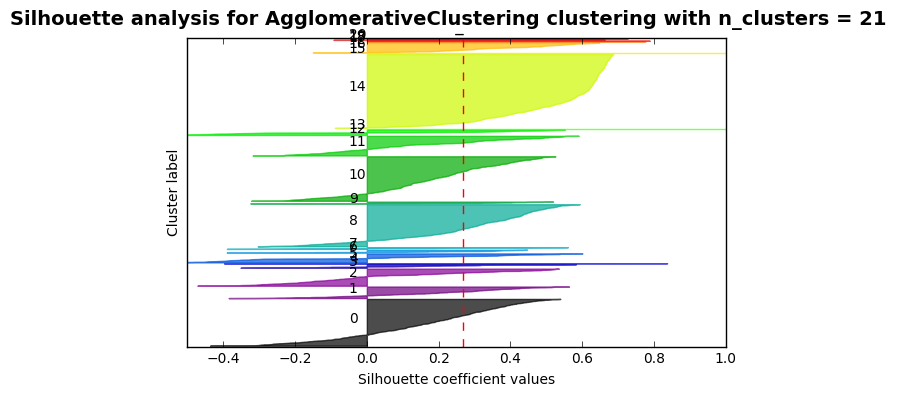

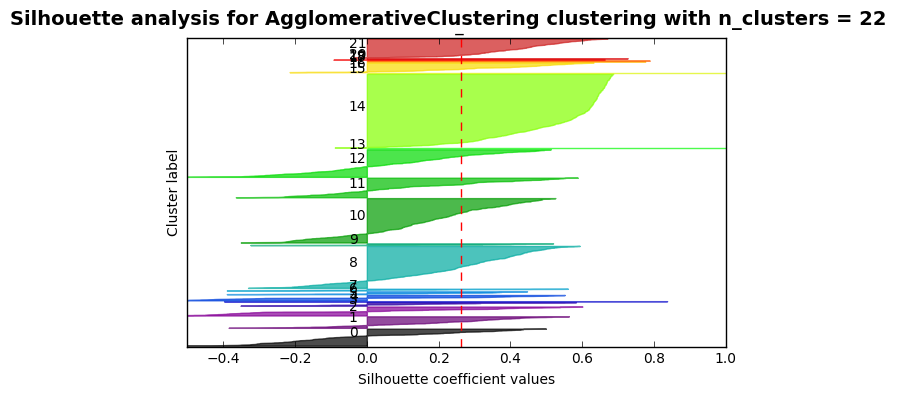

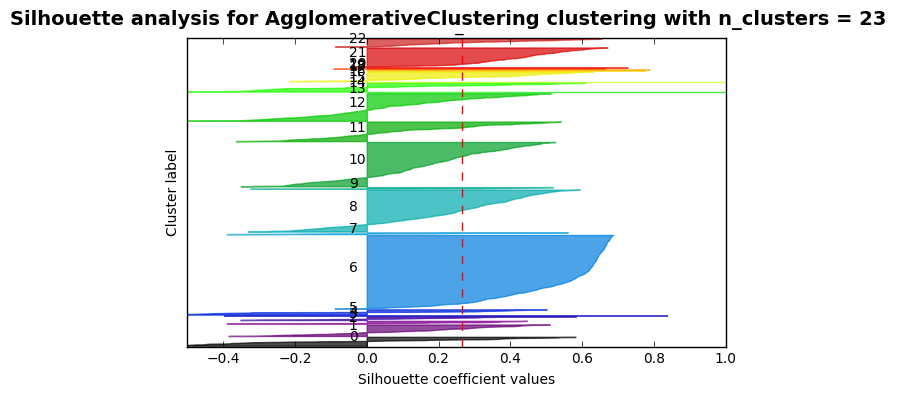

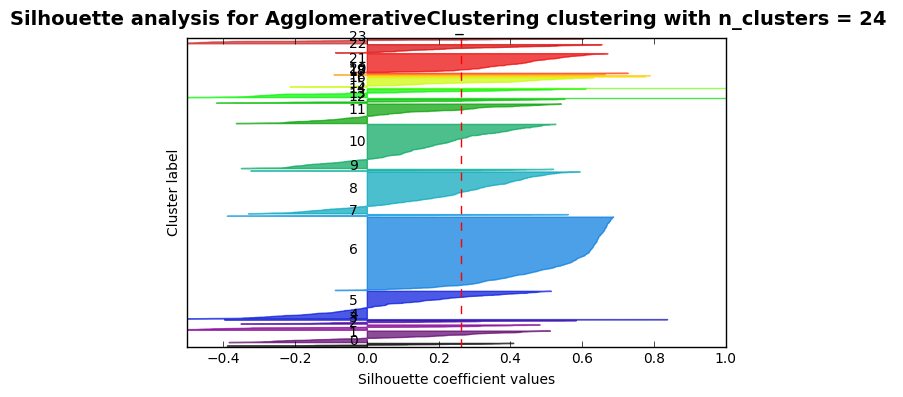

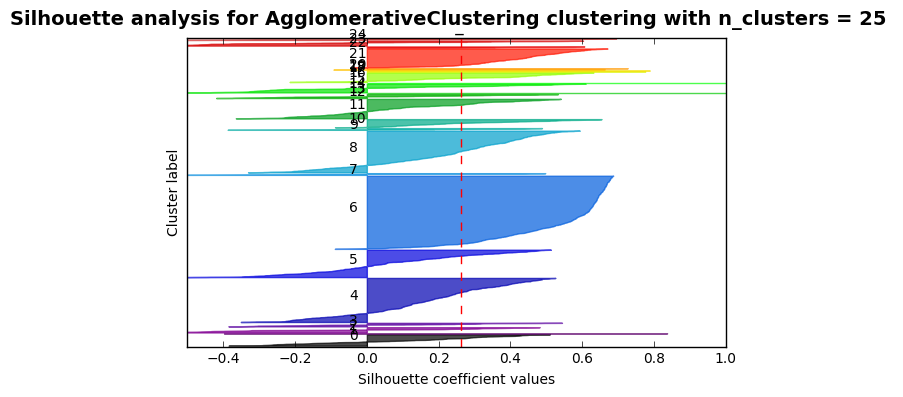

<IPython.core.display.Javascript object>


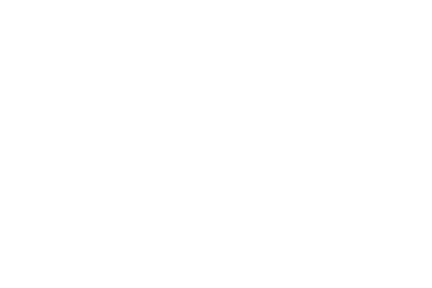

In [81]:
silhouette(cl.AgglomerativeClustering, max_clusters=25)